In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,auc
import cv2

In [2]:
data=pd.read_csv("fer2013.csv")

data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [21]:
data=data.drop('Usage',axis=1)

In [22]:
data.shape

(35887, 2)

In [23]:
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [24]:
data.isna()

,emotion,pixels
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
35882,False,False
35883,False,False
35884,False,False
35885,False,False


In [25]:
data['pixels'] = data['pixels'].apply(lambda x: x.reshape(48, 48, 1) if isinstance(x, np.ndarray) else np.array(x.split(), dtype='float32').reshape(48, 48, 1))

In [26]:
x = np.array([pixels for pixels in data['pixels']])

In [27]:
x.dtype

dtype('float32')

In [28]:
x.shape

(35887, 48, 48, 1)

In [29]:
y = data['emotion'].values

In [30]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=int64)

In [31]:
x=x/255.0

In [32]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(x)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Add
from tensorflow.keras.models import Model

input_layer = Input(shape=(48, 48, 1))

# First Block
hidden = Conv2D(64, (3, 3), padding='same')(input_layer)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Dropout(0.25)(hidden)
skip_connection = hidden  # Save output for later

# Second Block
hidden = Conv2D(128, (3, 3), padding='same')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Dropout(0.25)(hidden)

# Third Block
hidden = Conv2D(256, (3, 3), padding='same')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Dropout(0.25)(hidden)

# (Optional) Match shape if needed using Conv2D
skip_connection = Conv2D(256, (1, 1), padding='same')(skip_connection)
skip_connection = MaxPooling2D(pool_size=(4, 4))(skip_connection)  # downsample to match

# Add skip connection
hidden = Add()([hidden, skip_connection])

# Fully connected layers
hidden = Flatten()(hidden)
hidden = Dense(512)(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
hidden = Dropout(0.5)(hidden)
output_layer = Dense(7, activation='softmax')(hidden)

# Build model
model = Model(inputs=input_layer, outputs=output_layer)


In [41]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True)
    ]
)


In [42]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 48, 48, 64)   640         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 48, 48, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_11 (Activation)     (None, 48, 48, 64)   0           ['batch_normalization_11[0]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Set parameters
batch_size = 64
epochs = 50

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:

from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=7)
y_val_cat = to_categorical(y_val, num_classes=7)

In [47]:
# Create training data generator
train_generator = datagen.flow(x_train, y_train_cat, batch_size=batch_size)

# Train model
history = model.fit(train_generator, epochs=epochs, validation_data=(x_val, y_val_cat))

Epoch 1/50
449/449 [==============================] - 35s 56ms/step - loss: 2.1973 - accuracy: 0.2142 - precision: 0.2433 - recall: 0.0804 - auc: 0.5453 - val_loss: 2.0738 - val_accuracy: 0.2573 - val_precision: 0.5714 - val_recall: 0.0028 - val_auc: 0.6010
Epoch 2/50
449/449 [==============================] - 24s 53ms/step - loss: 2.0413 - accuracy: 0.2312 - precision: 0.2675 - recall: 0.0636 - auc: 0.5565 - val_loss: 1.7695 - val_accuracy: 0.2919 - val_precision: 0.4776 - val_recall: 0.0312 - val_auc: 0.6356
Epoch 3/50
449/449 [==============================] - 24s 53ms/step - loss: 1.9844 - accuracy: 0.2380 - precision: 0.2829 - recall: 0.0564 - auc: 0.5650 - val_loss: 1.7108 - val_accuracy: 0.3082 - val_precision: 0.5007 - val_recall: 0.0476 - val_auc: 0.6509
Epoch 4/50
449/449 [==============================] - 24s 53ms/step - loss: 1.9315 - accuracy: 0.2441 - precision: 0.2901 - recall: 0.0504 - auc: 0.5748 - val_loss: 1.7958 - val_accuracy: 0.2933 - val_precision: 0.4725 - val_r

225/225 [==============================] - 2s 7ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.42      0.47       985
           1       0.70      0.07      0.13       102
           2       0.69      0.08      0.15      1043
           3       0.71      0.86      0.78      1765
           4       0.53      0.23      0.33      1210
           5       0.66      0.75      0.70       795
           6       0.39      0.82      0.53      1278

    accuracy                           0.55      7178
   macro avg       0.60      0.46      0.44      7178
weighted avg       0.59      0.55      0.51      7178



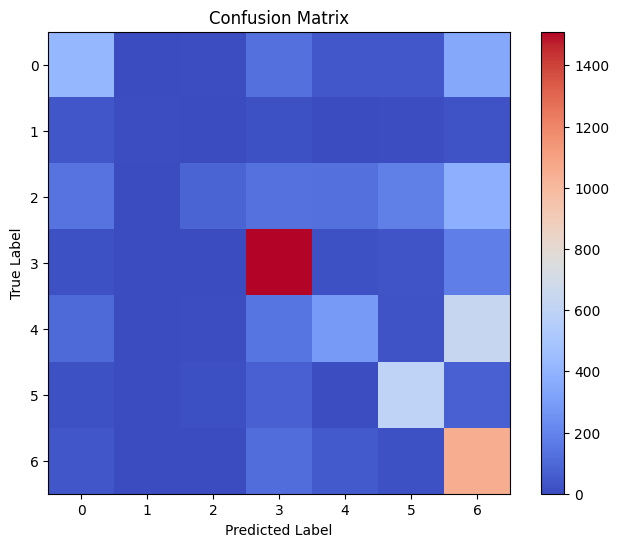

In [48]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = np.argmax(model.predict(x_val), axis=1)

# Convert one-hot to class indices
y_true = y_val

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()


In [56]:
import numpy as np

# Assuming x_test is a numpy array with shape (num_samples, 48, 48, 1)
# x_test[0] is the first image in your test set

# Preprocess the input (if needed)
x_sample = np.expand_dims(x_val[5], axis=0)  # Add batch dimension: (1, 48, 48, 1)

# Predict using the model
prediction = model.predict(x_sample)

# Print the prediction
print("Prediction:", prediction)

# If it's a classification problem, the output will be a probability distribution
# For the final predicted class, you can take the argmax (if using softmax)
predicted_class = np.argmax(prediction)
print("Predicted Class:", predicted_class)


1/1 [==============================] - 0s 29ms/step
Prediction: [[4.5025077e-01 8.7011920e-04 3.0336478e-03 4.5160006e-04 3.3444960e-02
  6.3532723e-05 5.1188540e-01]]
Predicted Class: 6


In [55]:
y_val[5]

6

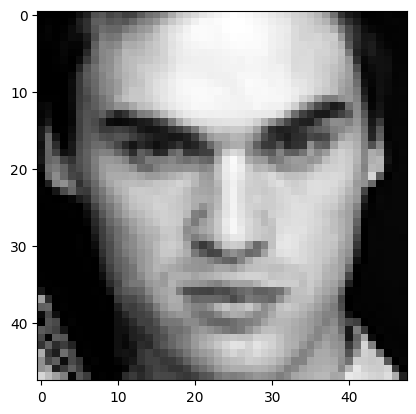

In [39]:
plt.imshow(x_val[5], cmap='gray')